# <center> LSE Earthquake Detection Challenge

###  <center> TEAM 5

##### <center> Xixiang Hu,
##### <center> Zhiyu Li,
##### <center> Qixuan Wu,
##### <center> Wen Xiang,
##### <center> Jiangchen Zhao

_Note: in alphabetical order by last name_

# INDEX   
### `Introduction`

### #`Preparations`

### `I. Data Preprocessing`   
* Labelling Techniques 

### `II. Modeling & Training`   
* PhaseNet Architecture   
* Build PhaseNet Model   
* Train & Save   

### `III. Model Evaluation`  
* Confusion Matrix  
* Number of Estimated Arrival Times Within 3s
* F1 Score


# Introduction
<span style = 'font-family: Times New Roman'>
The content of this section is from https://www.notion.so/LSE-Earthquake-Detection-Challenge-79b76c820e2b4a8280eff41ab3d99d1c.

## Earthquake Detection Challenge
<span style = 'font-family: Times New Roman'>
The aim of this challenge is to design and train a neural network for earthquake wave detection at Grillo seismic sensors.

### Dataset
<span style = 'font-family: Times New Roman'>
A network of about 20 Grillo instruments has been monitoring the southwest coast of Mexico since 2017. We are given segments with and without earthquake P-waves (a.k.a. signal and noise). The task will be to train a model that can distinguish between them.

- **Signal:** Roughly 1,223 earthquake records from Grillo stations. Each record comes from a single seismic station, has 3 independent channels (x, y, z) and is 2000 data samples long. The records are centered at earthquake P-wave, which starts always at data sample 1,000.
- **Noise:** Randomly selected noise segments from the data and non-earthquake disturbances. There are 17,850 noise segments. Noise segments are also 2,000 data samples long.

### The Goal
<span style = 'font-family: Times New Roman'>
The goal is to train a neural network for recognition of the P-wave onset. The neural network should be able to:

- Distinguish signal and noise sections (Figure 1 a and c).
- For signals, identify the P-wave arrival time with the precision of ±5 seconds (Figure 1 a vs e).
- For signals, identify the P-wave arrival time within 3 seconds after the P-wave arrival (Figure 1 a vs d).

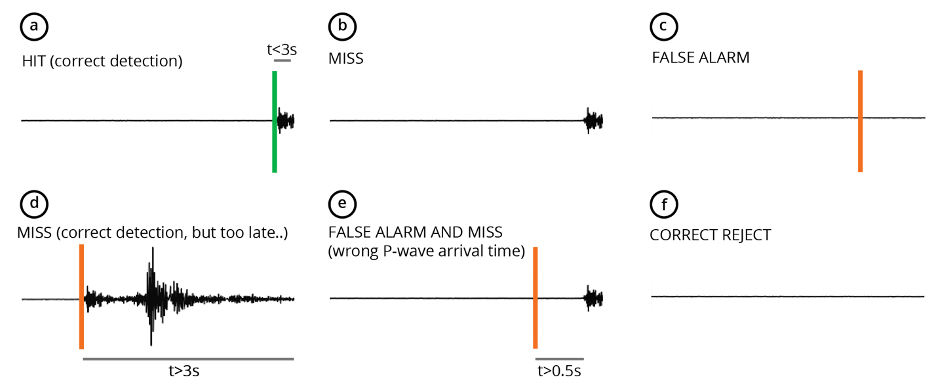
<span style = 'font-family: Times New Roman'>
Figure 1 | Different scenarios of signal/noise (mis)identification.

### Evaluation
<span style = 'font-family: Times New Roman'>
For the evaluation, we are expected to turn in a python code.

- **Code input:** 1000 data samples-long Obspy Trace object
- **Code output:** Time of the P-wave arrival (if present)

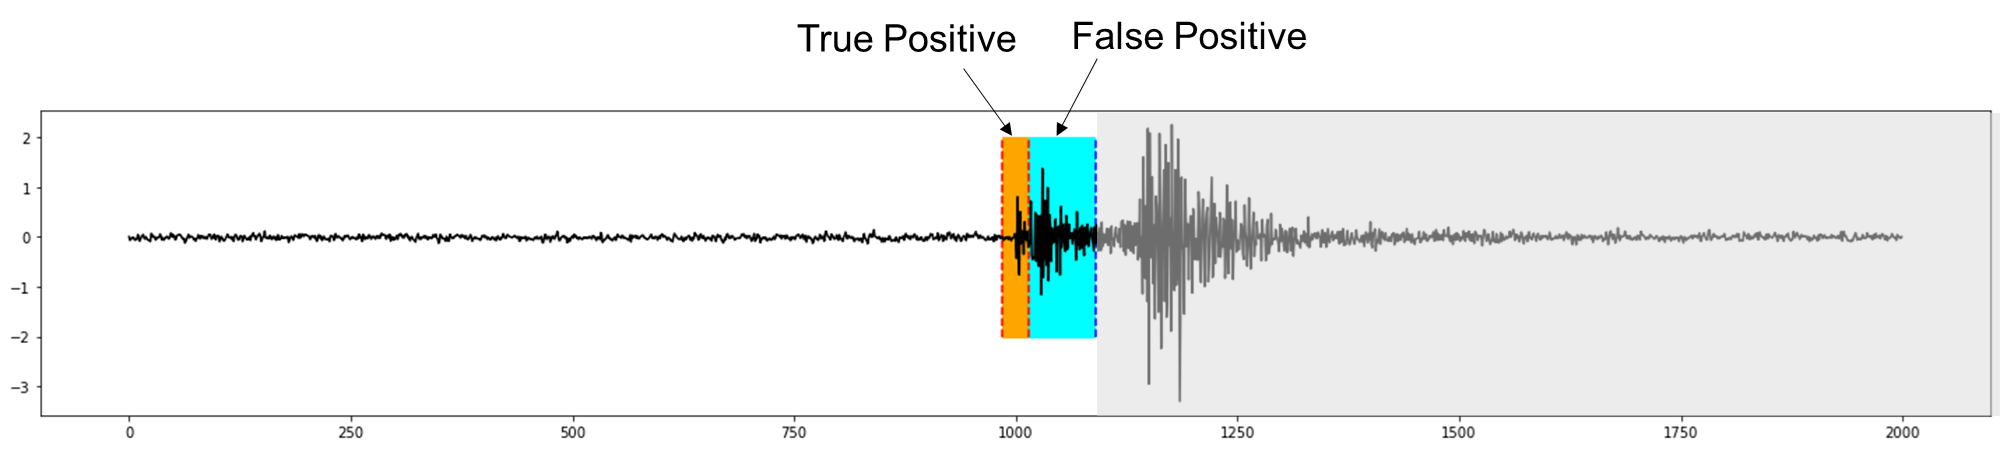

### #Preparations

#### Load Packages
__General ML__: `tensorflow`, `sklearn`    
__Seismological Data__: `obspy`   
__ML in Seismology__: `seisbench`    
__Data & Operations__: `numpy`   
__Visualization__: `matplotlib`    
__Operating System__: `os`    

_Note 1: "obspy" is installed as "Obspy" (pip install Obspy)._   
_Note 2: "os" is a standard library of Python._

In [1]:
import obspy
import os
import matplotlib.pyplot as plt
from numpy import diff
import numpy as np
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow import keras
import seisbench
import seisbench.models as sbm
import seisbench.data as sbd
from sklearn.metrics import confusion_matrix

2022-03-26 10:56:44.621675: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-03-26 10:56:50.272675: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-03-26 10:56:50.351409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 10:56:50.351995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-03-26 10:56:50.352039: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-03-26 10:56:50.371103: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-03-26 10:56:50.382460: I tensorflow/stream_executor/platform/default/d

#### Change Current Working Directory

In [3]:
cd /home/qixuanwu/lse_challenge/

/home/qixuanwu/lse_challenge


In [4]:
signalpath = os.getcwd() + r'/data/signal/'
noisepath = os.getcwd() + r'/data/noise/'

#### Create Filtered Data
<span style = 'font-family: Times New Roman'>
We filter the data in accordance to signal-noise ratio (SNR) and exclude those traces of low SNR. We use 999-1064 as our signal and divide it by noise from 935-999 to get our SNR calculation.

In [5]:
sig = os.listdir(signalpath)
snr = [0] * len(sig)
for i in range(len(sig)):
    st = obspy.read(signalpath + sig[i])
    r = 0
    for j in range(len(st)):
        tt = st[j].data
        s = sum(np.abs(tt[999:1064]))
        n = sum(np.abs(tt[935:999]))
        r += 20 * np.log10(s / n)
    snr[i] = r / 3
filtered = [idx for (idx, x) in enumerate(snr) if x >= 5]

In [6]:
noi = [f for f in listdir(noisepath) if isfile(join(noisepath, f))]
signaldata = [obspy.read(signalpath + sig[i]) for i in range(len(sig))]
signal = np.array([np.array([signaldata[i][0].data, signaldata[i][1].data,
                  signaldata[i][2].data]).T for i in
                  range(len(signaldata))])
noisedata = [obspy.read(noisepath + noi[i]) for i in range(len(noi))]
noise = np.array([np.array([noisedata[i][0].data, noisedata[i][1].data,
                 noisedata[i][2].data]).T for i in range(len(noisedata))])

In [7]:
signal_filtered = signal[filtered]
np.save('signal.npy', signal_filtered)
np.save('noise.npy', noise)

#### Load Filtered Data
<span style = 'font-family: Times New Roman'>
We filter the data in accordance to signal-noise ratio (SNR) and exclude those traces of low SNR. We treat all these data as three trace.

In [5]:
signal = np.load('signal.npy')
noise = np.load('noise.npy')
data = np.concatenate((signal[:,:,:], noise[:,:, :]))

## I. Data Preprocessing

#### Randomly Choose a Segment of Trace of 1000 Data Points

In [6]:
sampling_rate = 31.25
cut = np.random.choice(np.arange(15,110),len(signal)+len(noise),replace = True)

In [7]:
signal1=np.array([signal[i,cut[i]:cut[i]+1000,:] for i in range(len(signal))])
noise1=np.array([noise[i,cut[i+len(signal)]:cut[i+len(signal)]+1000,:] for i in range(len(noise))])
data = np.concatenate((signal1[:,:,:], noise1[:,:, :]))

_I. Data Preprocessing_
### Labelling techniques

In [8]:
all_noise = np.array([[1 for i in range(1000)], [0 for i in range(1000)]]).T
#arrival = np.array([1 if x > 994 and x < 1005 else 0 for x in range(2000)])
target = np.array([np.array([(np.arange(1000)<999-cut[i])*1, (np.arange(1000)>=999-cut[i])*1]).T for i in range(len(signal))]+[all_noise for i in range(len(noise))])

#### Split Data Into Training Set and Testing Set

In [9]:
np.random.seed(0)
train_idx = np.random.choice(np.arange(0, len(data)), int(len(data)*0.9),replace = False)
train_data = data[train_idx]
train_y = target[train_idx]
test_data = data[~np.isin(np.arange(len(data)), train_idx)]
test_y = target[~np.isin(np.arange(len(target)), train_idx)]

In [10]:
sgl=len([idx for idx,x in enumerate(test_y[:,:,1]) if x[999]==1])
arrival_idx=[list(test_y[:,:,1][i]==1).index(True) for i in range(sgl)]

## II. Modeling & Training

_II. Modeling & Training_
### PhaseNet Architecture

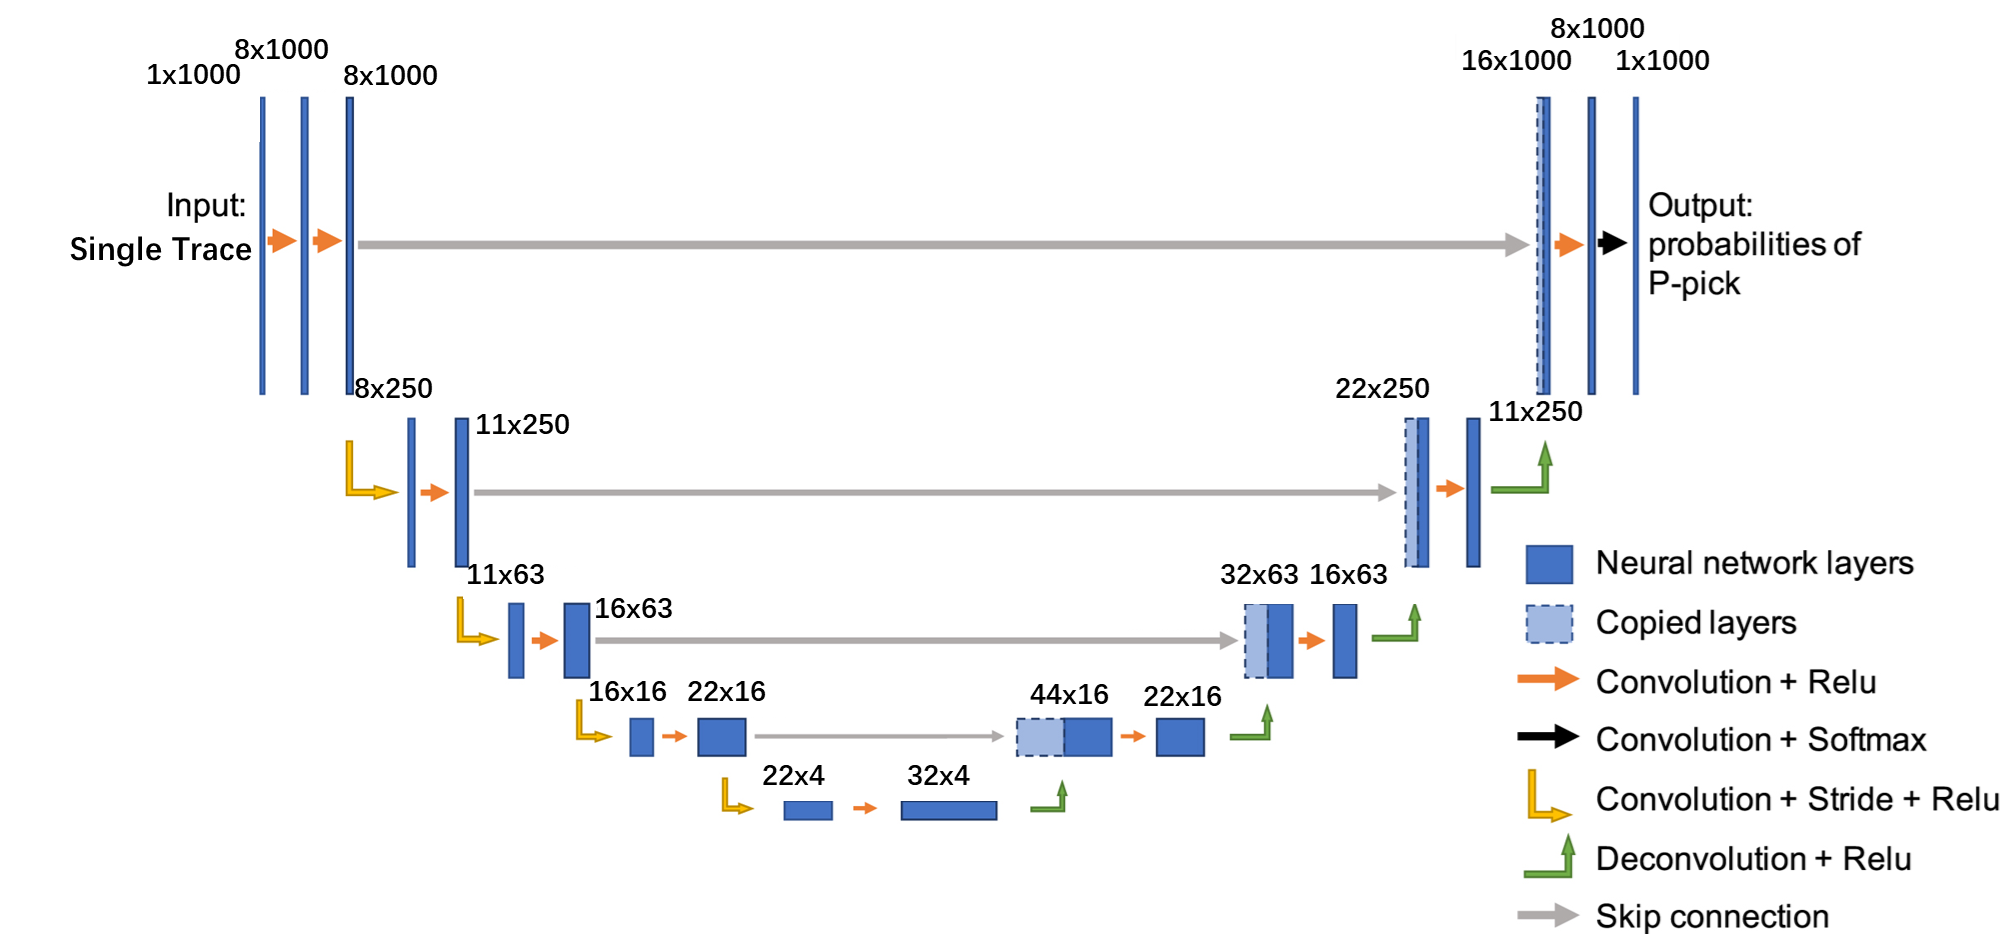
__Image Source__: https://academic.oup.com/view-large/figure/123811675/ggy423fig5.jpg   
__Ref__: Weiqiang Zhu, Gregory C Beroza, PhaseNet: a deep-neural-network-based seismic arrival-time picking method, Geophysical Journal International, Volume 216, Issue 1, January 2019, Pages 261–273, https://doi.org/10.1093/gji/ggy423.

_II. Modeling & Training_
### Build PhaseNet  model

In [11]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


#### Focal Loss  
<span style = 'font-family: Times New Roman'>
Focal loss is an improved version of cross-entropy which can handle the imbalance of classes. The formula of focal loss is: 

<p style="text-align: center;"> $FL(p_{t}) = -\alpha_{t}(1-p_{t})^{\gamma}log(p_{t})$ <p>

<span style = 'font-family: Times New Roman'>
$\gamma$ can be used to adjust the penalty to the misclassification of hard class. The higher $\gamma$ is, the heavier the penality will be. After several experiments, we find that $\gamma=3$ gives the best performance in this case.  

In [12]:
import tensorflow.keras.backend as K
def focal_loss(y_true, y_pred):
    gamma = 3
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred)) + 0.0001 # plus 0.0001 in case log(pt_1) goes to negative infinity
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred)) - 0.0001 # minus 0.0001 in case log(pt_0) goes to negative infinity
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [13]:
#---InputLayer---
S = keras.layers.Input((train_data.shape[1], train_data.shape[2]))

#---ConvLayer 1---
c1 = keras.layers.Conv1D(filters = 8, kernel_size = 7, strides = 1, kernel_initializer = 'he_normal', padding = 'same')(S)
c1 = keras.layers.BatchNormalization()(c1)
c1 = keras.layers.ReLU()(c1)
c1 = keras.layers.Conv1D(filters = 8, kernel_size = 7, strides = 1, kernel_initializer = 'he_normal', padding = 'same')(c1)
c1 = keras.layers.BatchNormalization()(c1)
c1 = keras.layers.ReLU()(c1)

#---ConvLayer 2---
c2 = keras.layers.Conv1D(filters = 8, kernel_size = 7, strides = 4, kernel_initializer = 'he_normal', padding = 'same')(c1)
c2 = keras.layers.BatchNormalization()(c2)
c2 = keras.layers.ReLU()(c2)
c2 = keras.layers.Conv1D(filters = 11, kernel_size = 7, strides = 1, kernel_initializer = 'he_normal', padding = 'same')(c2)
c2 = keras.layers.BatchNormalization()(c2)
c2 = keras.layers.ReLU()(c2)

#---ConvLayer 3---
c3 = keras.layers.Conv1D(filters = 11, kernel_size = 7, strides = 4, kernel_initializer = 'he_normal', padding = 'same')(c2)
c3 = keras.layers.BatchNormalization()(c3)
c3 = keras.layers.ReLU()(c3)
c3 = keras.layers.Conv1D(filters = 16, kernel_size = 7, strides = 1, kernel_initializer = 'he_normal', padding = 'same')(c3)
c3 = keras.layers.BatchNormalization()(c3)
c3 = keras.layers.ReLU()(c3)

#---ConvLayer 4---
c4 = keras.layers.Conv1D(filters = 16, kernel_size = 7, strides = 4, kernel_initializer = 'he_normal', padding = 'same')(c3)
c4 = keras.layers.BatchNormalization()(c4)
c4 = keras.layers.ReLU()(c4)
c4 = keras.layers.Conv1D(filters = 22, kernel_size = 7, strides = 1, kernel_initializer = 'he_normal', padding = 'same')(c4)
c4 = keras.layers.BatchNormalization()(c4)
c4 = keras.layers.ReLU()(c4)

#---ConvLayer 5---
c5 = keras.layers.Conv1D(filters = 22, kernel_size = 7, strides = 4, kernel_initializer = 'he_normal', padding = 'same')(c4)
c5 = keras.layers.BatchNormalization()(c5)
c5 = keras.layers.ReLU()(c5)
c5 = keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 1, kernel_initializer = 'he_normal', padding = 'same')(c5)
c5 = keras.layers.BatchNormalization()(c5)
c5 = keras.layers.ReLU()(c5)

#---ConvLayer 6---
d6 = keras.layers.Conv1DTranspose(44, 1, 4, padding = 'same')(c5)
d6 = keras.layers.concatenate([d6, c4])
c6 = keras.layers.Conv1D(filters = 22, kernel_size = 7, strides = 1, kernel_initializer = 'he_normal', padding = 'same')(d6)
c6 = keras.layers.BatchNormalization()(c6)
c6 = keras.layers.ReLU()(c6)

#---ConvLayer 7---
d7 = keras.layers.Conv1DTranspose(32, 18, 3)(c6) #When the length of data is 2000---in the original stream format
#d7 = keras.layers.Conv1DTranspose(32, 32,3)(c6) #When the length of data is 2000---in the original stream format
#d7 = keras.layers.Conv1DTranspose(32, 4,4)(c6) #When the length of data is 6400---the format after being denoised
d7 = keras.layers.concatenate([d7, c3])
c7 = keras.layers.Conv1D(filters = 16, kernel_size = 7, strides = 1, kernel_initializer = 'he_normal', padding = 'same')(d7)
c7 = keras.layers.BatchNormalization()(c7)
c7 = keras.layers.ReLU()(c7)

#---ConvLayer 8---
d8 = keras.layers.Conv1DTranspose(22, 64, 3)(c7)
d8 = keras.layers.concatenate([d8, c2])
c8 = keras.layers.Conv1D(filters = 11, kernel_size = 7, strides = 1, kernel_initializer = 'he_normal', padding = 'same')(d8)
c8 = keras.layers.BatchNormalization()(c8)
c8 = keras.layers.ReLU()(c8)

#---ConvLayer 9---
d9 = keras.layers.Conv1DTranspose(16, 4, 4, padding = 'same')(c8)
d9 = keras.layers.concatenate([d9, c1])
c9 = keras.layers.Conv1D(filters = 8, kernel_size = 7, strides = 1, kernel_initializer = 'he_normal', padding = 'same')(d9)
c9 = keras.layers.BatchNormalization()(c9)
c9 = keras.layers.ReLU()(c9)

#---OutputLayer---
output = keras.layers.Conv1D(filters = 2, kernel_size = 1, strides = 1, activation = 'softmax')(c9)


seg_model = keras.models.Model(inputs = S, outputs = [output])

seg_model.compile(
    # Optimization algorithm, specify learning rate
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    # Loss function for a binary classifier
    #loss='binary_crossentropy',
    loss = [focal_loss],
    # Diagnostic quantities
    metrics=['accuracy'])

seg_model.summary()


2022-03-26 10:57:15.880137: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2199995000 Hz
2022-03-26 10:57:15.880337: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555aaea0d170 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-26 10:57:15.880362: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-26 10:57:16.043773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 10:57:16.044415: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555aae2d2bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-03-26 10:57:16.044435: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2022-03-2

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1000, 8)      176         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1000, 8)      32          conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1000, 8)      0           batch_normalization[0][0]        
_______________________________________________________________________________________

_II. Modeling & Training_
### Train  model

In [ ]:
seg_model.fit(train_data, train_y, epochs = 20, batch_size = 32)

2022-03-26 11:10:11.499123: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 204072000 exceeds 10% of free system memory.
2022-03-26 11:10:11.654458: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 272096000 exceeds 10% of free system memory.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/20
532/532 [==============================] - 47s 89ms/step - loss: 173.9244 - accuracy: 0.9983
Epoch 2/20
532/532 [==============================] - 47s 88ms/step - loss: 131.4546 - accuracy: 0.9990
Epoch 3/20
532/532 [==============================] - 48s 90ms/step - loss: 104.8416 - accuracy: 0.9991
Epoch 4/20
532/532 [==============================] - 47s 88ms/step - loss: 81.7978 - accuracy: 0.9992
Epoch 5/20
532/532 [==============================] - 47s 88ms/step - loss: 63.8725 - accuracy: 0.9993
Epoch 6/20
532/532 [==============================] - 47s 88ms/step - loss: 50.7881 - accuracy: 0.9994
Epoch 7/20
532/532 [==============================] - 47s 88ms/step - loss: 39.4593 - accuracy: 0.9994
Epoch 8/20
532/532 [==============================] - 47s 89ms/step - loss: 31.2666 - accuracy: 0.9995
Epoch 9/20
532/532 [==============================] - 46s 87ms/step - loss: 24.9331 - accuracy: 0.9995
Epoch 10/20
347/532 [==================>...........] - ETA: 16s - loss

_II. Modeling & Training_
### Save  model

In [15]:
seg_model.save(os.getcwd()+'PHFOCAL100.h5')

_II. Modeling & Training_
### Load  model

In [16]:
model = tf.keras.models.load_model(os.getcwd()+'PHFOCAL100.h5', custom_objects={"focal_loss": focal_loss })

_II. Modeling & Training_
### Get prediction

In [17]:
pred = model.predict(test_data)

## III. Model Evaluation

#### Convert Probability to Class

In [18]:
def PredClass(test_data, threshold = 0):
    Class = []
    for tensor in pred[:,:,1]:
        if sum(tensor > 0.5) > threshold:
            Class.append(1)
        else:
            Class.append(0)
    return np.array(Class).reshape((1, len(test_data)))

PredClass = PredClass(test_data)

#### Real Class

In [19]:
RealClass = np.array([np.arange(len(data))[~np.isin(np.arange(len(data)), train_idx)] <signal.shape[0]], dtype = 'int')

_III. Model Evaluation_
### Confusion Matrix

In [20]:
confusion_matrix(list(RealClass[0]), list(PredClass[0]))

array([[1760,   16],
       [   7,  107]])

_III. Model Evaluation_
### Number of Estimated Arrival Times Within 3s

In [34]:
def good_estimation(ub = 0.5, lb = -0.5, delta = 0.032):
    good_point, bad_point, point_count,miss = 0, 0, 0, 0
    for i in range(sgl):
        if  max(pred[:,:,1][i])<0.5:
            miss += 1
        else:
            pred_idx = list(pred[:,:,1][i] > 0.5).index(True)
            if (pred_idx < arrival_idx[i] + ub/delta) and (pred_idx>= arrival_idx[i] +lb/delta):
                good_point += 1
            else:
                bad_point += 1

        point_count += 1

    return {'Good Estimation': good_point, 'Bad Estimation': bad_point, 'Miss':miss, 'Count':point_count}

good_estimation()

{'Good Estimation': 95, 'Bad Estimation': 12, 'Miss': 7, 'Count': 114}

In [35]:
def noise_recognition(ub = 0.5, lb = -0.5, delta = 0.032):
    good_point, bad_point, point_count= 0, 0, 0
    for i in range(sgl,len(pred[:,:,1])):
        if  max(pred[:,:,1][i])<0.5:
            good_point += 1
        else:
            bad_point += 1        
        point_count += 1

    return {'Good Estimation': good_point, 'Bad Estimation': bad_point, 'Count':point_count}
noise_recognition()

{'Good Estimation': 1760, 'Bad Estimation': 16, 'Count': 1776}

_III. Data Evaluation_
### F1 Score

In [37]:
tn, fn = noise_recognition()['Good Estimation'], good_estimation()['Bad Estimation'] + good_estimation()['Miss']
fp, tp = noise_recognition()['Bad Estimation'], good_estimation()['Good Estimation']

def FScore(tn, fn, fp, tp):
    return 2*((tp/(tp+fp)) * (tp/(tp + fn))) / ((tp/(tp+fp)) + (tp/(tp + fn)))
FScore(909, 17, 0, 269)

0.8444444444444446

In [38]:
import glob
import random
import numpy as np
#import detector
from obspy.core import read
import matplotlib.pyplot as plt

In [39]:
# set variables
random.seed(0)
accuracy = .5 # max time difference in seconds
p_win = (.5, 3) # setting limits for P-wave 
sampling_rate = 31.25
min_snr = 1.5
datapath = 'D:/Download/lse_eval/validation_data'
#datapath = 'D:/Download/lse_challenge/lse_challenge/data/signal/'
hit = 0; miss = 0; false_alarm = 0; correct_rejection = 0
hit_accuracy = []

# get all filenames
valid_filenames = [f for f in glob.glob(datapath + "/*/*")]
#valid_filenames = [f for f in glob.glob(datapath + "*")]
number_of_files = len(valid_filenames)
number_of_noise = len([f for f in valid_filenames if "_N" in f])
number_of_pwave = number_of_files-number_of_noise

#### Detector
<span style = 'font-family: Times New Roman'>
Applying averaging strategy in detector could make the prediction more robust and reduce the variance in theory.

In [40]:
def predict(tr):
    predictor = model
    
    global arr0, arr1, prediction, idx0, idx1

    arr0 = tr

    # Determine the order of input trace, the 1st? 2nd? 3rd?
    try:
        if arr0.stats.starttime == arr1.stats.starttime:
            order = 2
            try:
                if arr0.stats.starttime == arr2.stats.starttime:
                    order = 3
            except:
                pass

        else:
            order = 1
    except:
        order = 1



    # If it is the 1st trace, then predict directly.
    if order == 1:
        prob = predictor.predict(tr.data.reshape((1, 1000,1)))
        try:
            idx = list(prob[0,:,1] > 0.5).index(True)
            prediction = tr.stats.starttime + tr.stats.delta * idx

        except:
            prediction = None

    # If it is the 2nd trace, if both the two traces are not None, then use the average prediction as the prediction.
    # If one of the prediction is None, use the other prediction as the final prediction.
    if order == 2:
        prob = predictor.predict(tr.data.reshape((1, 1000,1)))
        try:
            idx0 = list(prob[0,:,1] > 0.5).index(True)
            pred0 = tr.stats.starttime + tr.stats.delta * idx0

        except:
            pred0 = None

        prob = predictor.predict(arr1.data.reshape((1, 1000,1)))
        try:
            idx1 = list(prob[0,:,1] > 0.5).index(True)
            pred1 = tr.stats.starttime + tr.stats.delta * idx1

        except:
            pred1 = None

        if (pred1 == None) and (pred0 == None):
            prediction = None
        elif (pred1 == None) and (pred0 != None):
            prediction = pred0
        elif (pred1 != None) and (pred0 == None):
            prediction = pred1

        else:
            prediction = tr.stats.starttime + tr.stats.delta * (idx1 + idx0)/2

    # If it is the 3rd trace, use the average prediction as the final prediction.
    if order == 3:
        prob = predictor.predict(tr.data.reshape((1, 1000,1)))
        try:
            idx0 = list(prob[0,:,1] > 0.5).index(True)
            pred0 = tr.stats.starttime + tr.stats.delta * idx

        except:
            pred0 = None

        if pred0 == None:
            pass

        else:
            prob = predictor.predict(arr1.data.reshape((1, 1000,1)))
            try:
                idx1 = list(prob[0,:,1] > 0.5).index(True)
                pred1 = tr.stats.starttime + tr.stats.delta * idx

            except:
                pred1 = None

            prob = predictor.predict(arr2.data.reshape((1, 1000,1)))
            try:
                idx2 = list(prob[0,:,1] > 0.5).index(True)
                pred2 = tr.stats.starttime + tr.stats.delta * idx

            except:
                pred2 = None

            if (pred2 == None) and (pred1 == None):
                prediction = pred0


            elif (pred2 != None) and (pred1 == None):
                prediction = tr.stats.starttime + tr.stats.delta * (idx2 + idx0)/2

            elif (pred2 == None) and (pred1 != None):
                prediction = tr.stats.starttime + tr.stats.delta * (idx1 + idx0)/2


            else:
                prediction = tr.stats.starttime + tr.stats.delta * (idx2 + idx1 + idx0)/3



    try:
        arr2, arr1 = arr1, arr0
    except:
        arr1 = arr0
    
    return prediction

#### Validate

In [41]:
# iterate over all files in validation set
for f in valid_filenames:

    print("File: {}".format(f))

    # read in the file
    st = read(f)
    cut = int((random.random()*p_win[1]+p_win[0])*sampling_rate)

    # iterate over traces in mseed files
    for tr in st:

        # there was a comment raised during one of the sessions that some p-waves have very low signal-to-noise ratio
        # here I require all p-waves to have snr 1.5 or greater
        # snr is calcuated as a ratio of sums of abs values of waveforms 1s before and 1s after p-wave arrival
        snr = sum(abs(tr.data[1000:1032]))/sum(abs(tr.data[1000-32:1000]))

        # in case of small snr, just print a message
        if "_P" in f and snr<=min_snr:
            print("  Channel: {}, passing, not high-enough P wave S/N ratio ({:4.2f})".format(tr.stats.channel, snr))      
        
        # otherwise do everything
        else:
            tr.data = tr.data[cut:1000+cut]

            # set correct answers
            if "_N" in f:
                # if it is a noise segment, the correct answer is None
                correct_answer = None
            else:
                # if it is a p-wave segment, the correct answer is the p-wave arrival time (UTCDateTime format)
                correct_answer = tr.stats.starttime + (1000-cut)/tr.stats.sampling_rate

            """
            Your magic starts here.
            Here you are given an obspy trace. Your should determine whether it contains a p-wave.
            If so, return time of the p-wave arrival. If not, return None.
            Swap my function below with yours.

            :param: tr (``obspy Trace``) --
                1000-samples-long obspy Trace that eiter contains p-wave or not.
        
            :return: prediction (``obspy UTCDateTime`` or None) --
                Time of the P-wave detection or None if none detected.
            """
            
        
            prediction = predict(tr)
                
        

            
            """
            Your magic ends here.
            prediction variable needs to be either UTCDateTime object or None.
            """

            # Evaluation logic
            # noise segment, no p-wave detected
            if prediction is None and correct_answer is None:
                correct_rejection += 1
                print("  Channel: {}, correct rejection!".format(tr.stats.channel))
            
            # p-wave segment but no detection
            elif prediction is None and correct_answer is not None:
                miss += 1
                print("  Channel: {}, miss!".format(tr.stats.channel))

            # p-wave falsely detected in noise segment
            elif prediction is not None and correct_answer is None:
                false_alarm += 1
                print("  Channel: {}, false alarm!".format(tr.stats.channel))

            # p-wave detected in p-wave segment
            else:
                # evaluate if the detection is accurate enough, if so it is a hit...
                if abs(correct_answer-prediction)<=accuracy:
                    hit += 1
                    hit_accuracy.append(correct_answer-prediction)
                    print("  Channel: {}, hit, accuracy {:4.2f}s !".format(tr.stats.channel, correct_answer-prediction))
                
                # ...else it is unfortunately a miss.
                else:
                    miss += 1
                    hit_accuracy.append(correct_answer-prediction)
                    print("  Channel: {}, miss, error {:4.2f}s !".format(tr.stats.channel, correct_answer-prediction))

In [42]:
# calculate the stats
precision = hit/(hit+false_alarm)
recall = hit/(hit+miss)
f1score = (2*precision*recall)/(precision+recall)

# and print them
print(' ')
print('EVALUATING THE MODEL BY:')
print(' ')
print('{:5.0f} Validation segments'.format(number_of_files))
print('{:5.0f} contains a P-wave'.format(number_of_pwave))
print('{:5.0f} is noise'.format(number_of_noise))
print(' ')
print('MODEL PREDICTION EVALUATION')
print('---------------------------')
print(' ')
print('         |         |         |')
print('         |    P    |  noise  |')
print('---------|---------|---------|')
print('   Tag   |  {:5.0f}  |  {:5.0f}  |'.format(hit, false_alarm))
print('---------|---------|---------|')
print(' No tag  |  {:5.0f}  |  {:5.0f}  |'.format(miss, correct_rejection))
print('---------|---------|---------|')
print(' ')
print('Precision: {:4.2f}'.format(precision))
print('Recall: {:4.2f}'.format(recall))
print('Hit misfit: mean {:4.2f}, std {:4.2f}'.format(np.array(hit_accuracy).mean(), np.array(hit_accuracy).std()))
print(' ')
print('////////////////////')
print('// F1 score: {:4.2f} //'.format(f1score))
print('////////////////////')
print(' ')

# plot misfits
out = plt.hist(hit_accuracy, bins=np.arange(-2, 2, .05))
plt.vlines(-accuracy, 0, max(out[0]), color=[.2, .2, .2])
plt.vlines(accuracy, 0, max(out[0]), color=[.2, .2, .2])
plt.xlabel("Misfit [s]")
plt.ylabel("Number of segments")
plt.savefig("misfit.png")
plt.show()

ZeroDivisionError: division by zero